## 2022-10-16
#### Tambovtsev Roman
#### Final Project
#### Libraries Python for DataScince
#### Predicting the cost of an apartment

### 1. Подключение необходимых библиотек

In [34]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 10})


## 1.1 Функция для расчёта метрики

In [35]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print('Train R2:\t' + str(round(r2(train_true_values, train_pred_values), 3)))
    print('Test R2:\t' + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

### 2. Знакомство с DataSet

2.1 Тренировочный набор

In [36]:
Train_DataSet_Path = '../input/real-estate-price-prediction-moscow/train.csv'
Test_DataSet_Path = '../input/real-estate-price-prediction-moscow/test.csv'

In [37]:
train_df = pd.read_csv(Train_DataSet_Path, delimiter = ',')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


Смотрим тип фичей

In [38]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [39]:
train_df.shape

(10000, 20)

2.1 Тестовый набор

In [40]:
test_df = pd.read_csv(Test_DataSet_Path, delimiter = ',')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [41]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [42]:
test_df.shape

(5000, 19)

Изменим тип данных у фичей Rooms и HouseFloor с float на int, т.к. они имеют только целые значения

In [43]:
train_df[['Rooms', 'HouseFloor']] = train_df[['Rooms', 'HouseFloor']].astype(int)

In [44]:
test_df[['Rooms', 'HouseFloor']] = test_df[['Rooms', 'HouseFloor']].astype(int)

In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  int64  
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [46]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   int64  
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   int64  
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [47]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### 3. Уменьшение разряда данных для уменьшения размера занимаемой памяти

In [48]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    df[['Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']] \
    = df[['Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']]\
    .astype('float32')  # строка для последующего использоваия MinMaxScaler()

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [49]:
reduce_train_df = reduce_mem_usage(train_df)
reduce_train_df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.55 MB
Decreased by 63.7%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3,115.027313,NaN,10.0,4,10,2014,0.075424,B,B,11.0,3097.0,0.0,NaN,0.0,0.0,B,305018.875000
1,3013,22,1,39.832523,23.169222,8.0,7,8,1966,0.118537,B,B,30.0,6207.0,1.0,1183.0,1.0,0.0,B,177734.546875
2,8215,1,3,78.342216,47.671970,10.0,2,17,1988,0.025609,B,B,33.0,5261.0,0.0,240.0,3.0,1.0,B,282078.718750
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,B,B,1.0,264.0,0.0,NaN,0.0,1.0,B,168106.000000
4,13866,94,2,64.285065,38.562515,9.0,16,16,1972,0.282798,B,B,33.0,8667.0,2.0,NaN,0.0,6.0,B,343995.093750


In [50]:
reduce_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  float32 
 13  Social_2       10000 non-null  float32 
 14  Social_3       10000 non-null  float32 
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  float32 
 17  Shops_1        10000 non-null  f

In [51]:
reduce_test_df = reduce_mem_usage(test_df)
reduce_test_df.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.25 MB
Decreased by 65.7%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1,36.847630,19.094183,5.0,5,9,1970,0.036122,B,B,24.0,4378.0,0.0,1036.0,1.0,1.0,B
1,5925,62,1,42.493908,42.568134,10.0,7,17,2017,0.072158,B,B,2.0,629.0,1.0,NaN,0.0,0.0,A
2,960,27,2,59.463676,NaN,9.0,19,19,1977,0.211401,B,B,9.0,1892.0,0.0,NaN,0.0,1.0,B
3,3848,23,3,49.646030,33.893826,6.0,2,2,1965,0.014073,B,B,2.0,475.0,0.0,NaN,0.0,0.0,B
4,746,74,1,53.837055,NaN,1.0,8,17,1977,0.309479,B,B,35.0,7715.0,4.0,990.0,0.0,6.0,B


In [52]:
reduce_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   int8    
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   int8    
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   float32 
 13  Social_2       5000 non-null   float32 
 14  Social_3       5000 non-null   float32 
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   float32 
 17  Shops_1        5000 non-null   fl

### 4. EDA (exploration data analysis)

In [53]:
reduce_train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.00000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.140625,8.039200,1142.904419,1.31950,4.231300,214138.937500
std,4859.01902,43.587592,0.839512,21.058716,86.241219,28.560839,5.241148,6.775974,2.005003e+05,0.119025,17.532627,4006.817627,23.831953,1021.519470,1.49358,4.806355,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.00000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.00000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,633233.437500


In [59]:
r_train_df = reduce_train_df

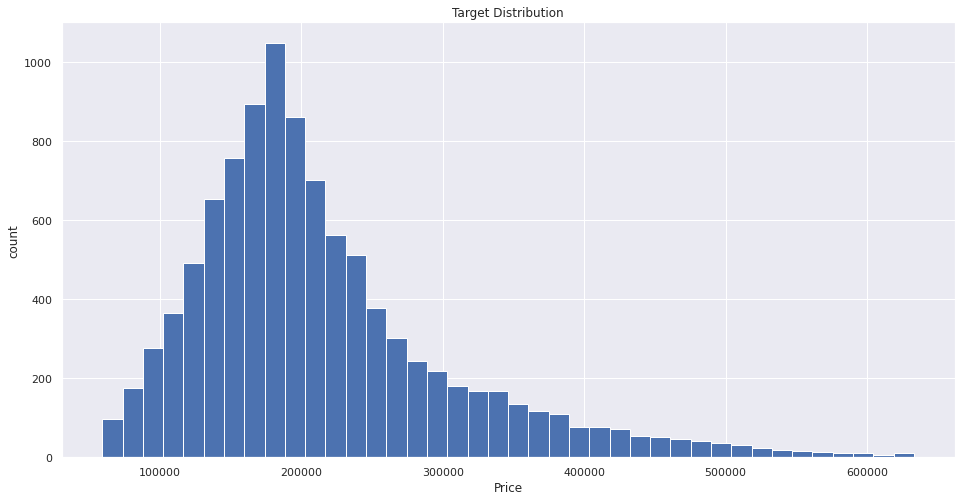

In [60]:
plt.figure(figsize = (16, 8))

reduce_train_df['Price'].hist(bins=40)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Target Distribution')
plt.show()

* Данные без выбросов

Посморим, что покажет корреляция признаков. Можно сразу предположить зависимость стоимости от площади

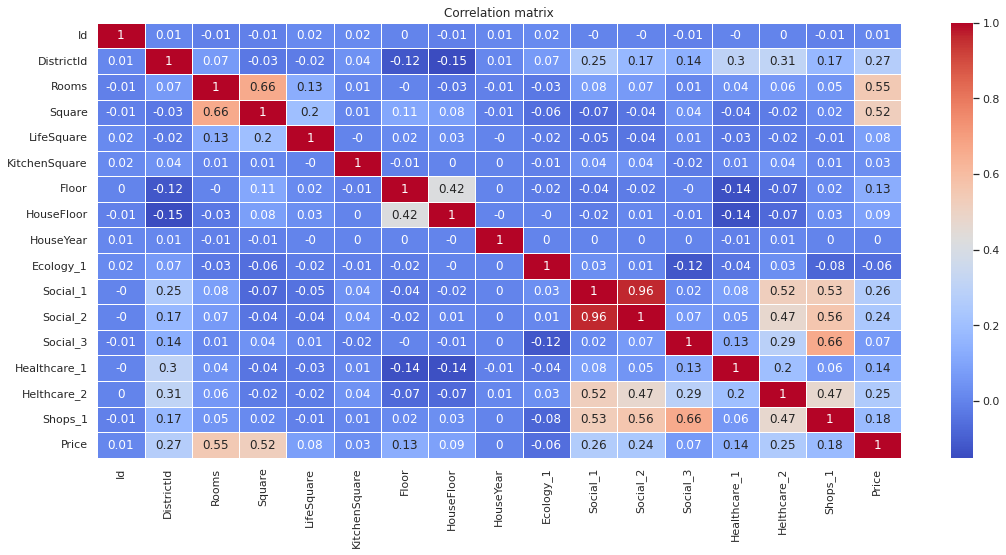

In [61]:
plt.figure(figsize = (18,8))

sns.set(font_scale=1)

correlation_matrix = np.round(reduce_train_df.corr(),2)
sns.heatmap(correlation_matrix, annot=True, linewidths=1, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

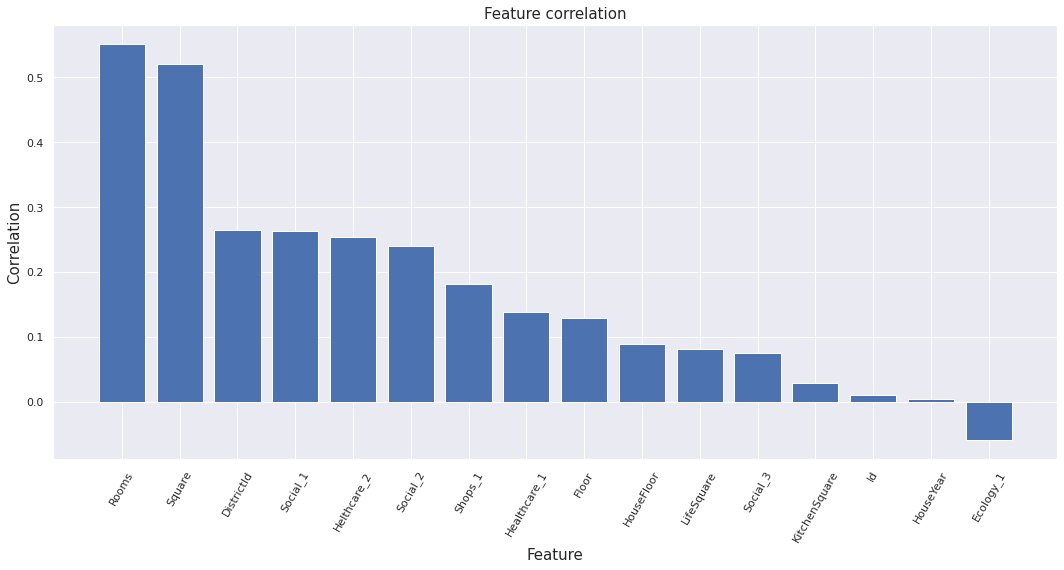

In [62]:
correlation = r_train_df.corrwith(r_train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (18,8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='60')
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)

plt.show()

In [63]:
reduce_train_df.select_dtypes(include='category')

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B
...,...,...,...
9995,B,B,B
9996,B,B,A
9997,B,B,B
9998,B,B,B


In [64]:
r_train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [65]:
r_train_df = reduce_train_df
r_train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [66]:
r_train_df = reduce_train_df
r_train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [67]:
r_train_df.sort_values('HouseYear')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6794,13288,161,1,50.808926,15.920343,20.0,8,9,1910,0.014423,B,B,19.0,3806.0,4.0,NaN,0.0,3.0,B,287954.718750
2795,2085,161,1,63.293079,29.389814,18.0,3,9,1912,0.014423,B,B,19.0,3806.0,4.0,NaN,0.0,3.0,B,262279.812500
2066,14556,183,4,151.150665,98.187485,23.0,6,7,1912,0.037316,B,B,32.0,6748.0,93.0,562.0,4.0,10.0,B,284884.968750
6250,6751,172,2,56.172363,28.384212,7.0,8,6,1914,0.000000,B,B,7.0,1660.0,39.0,1786.0,1.0,5.0,B,423580.468750
7610,7920,183,3,102.964470,48.322105,14.0,4,6,1916,0.037316,B,B,32.0,6748.0,93.0,562.0,4.0,10.0,B,284608.937500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8296,8832,1,3,83.260742,79.438324,1.0,15,21,2020,0.007122,B,B,1.0,264.0,0.0,NaN,0.0,1.0,B,242243.093750
2350,14318,53,2,57.815311,37.287064,8.0,6,24,2020,0.049637,B,B,34.0,7759.0,0.0,229.0,1.0,3.0,B,251249.359375
7246,7026,62,1,44.019287,46.759315,1.0,7,12,2020,0.072158,B,B,2.0,629.0,1.0,NaN,0.0,0.0,A,135588.218750
8828,11607,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,B,B,25.0,4756.0,16.0,2857.0,5.0,8.0,B,243028.609375


### 4.1 Обработка выбросов по количеству и площади комнат, кухни, году постройки и этажности

Заменяем 0 комнат и более 6 на 1 комнату

In [68]:
r_train_df.loc[(r_train_df['Rooms'] == 0) | (r_train_df['Rooms'] >= 6), 'Rooms'] = 1

Корректируем Square (Общую площадь)

In [69]:
r_train_df.loc[(r_train_df['Rooms'] <= 3) & (r_train_df['Square'] > 100), 'Square'] \
= r_train_df['Square'] / 10

In [70]:
r_train_df.loc[(r_train_df['Rooms'] < 3) & (r_train_df['Square'] < 10), 'Square'] \
= r_train_df['Square'] * 10

In [71]:
r_train_df.loc[(r_train_df['Rooms'] == 3) & (r_train_df['Square'] < 70), 'Square'] \
= r_train_df['Square'].quantile(.75)

In [72]:
r_train_df.loc[(r_train_df['Rooms'] == 2) & (r_train_df['Square'] < 70), 'Square'] \
= r_train_df['Square'].quantile(.5)

In [73]:
r_train_df.loc[(r_train_df['Rooms'] == 1) & (r_train_df['Square'] < 25), 'Square'] \
= r_train_df['Square'].quantile(.25)

Корректируем Площадь кухни

In [74]:
r_train_df.loc[(r_train_df['KitchenSquare'] >= 10) & (r_train_df['Square'] > 100),'KitchenSquare'] = 20

In [75]:
r_train_df.loc[(r_train_df['KitchenSquare'] < 10) & (r_train_df['Square'] < 100),'KitchenSquare'] \
= r_train_df['Square'] * 0.2

In [76]:
r_train_df.loc[(r_train_df['KitchenSquare'] < 10) & (r_train_df['Square'] > 100),'KitchenSquare'] \
= r_train_df['Square'] * 0.2

In [77]:
r_train_df.loc[(r_train_df['KitchenSquare'] > 10) & (r_train_df['Square'] < 100),'KitchenSquare'] \
= r_train_df['Square'] * 0.2

Корректируем Год постройки

In [78]:
r_train_df.loc[(r_train_df['HouseYear'] == 4968), 'HouseYear'] = 1968

Корректируем жилую площадь

In [79]:
koef_Life_Square = (r_train_df['LifeSquare'] / r_train_df['Square']).quantile(.5)

In [80]:
r_train_df.loc[(r_train_df['LifeSquare'] <= 15),'LifeSquare'] \
= r_train_df['Square'] * koef_Life_Square

In [81]:
r_train_df.loc[(r_train_df['LifeSquare'].isna()),'LifeSquare'] \
= r_train_df['Square'] * koef_Life_Square

In [82]:
r_train_df.loc[(r_train_df['LifeSquare'] > r_train_df['Square']),'LifeSquare'] \
= r_train_df['Square'] * koef_Life_Square

Корректируем этажность

In [83]:
r_train_df.loc[(r_train_df['HouseFloor'] <  r_train_df['Floor']) | (r_train_df['HouseFloor'] >  48)\
               ,'HouseFloor'] = r_train_df['Floor']

In [84]:
r_train_df['HouseFloor'].value_counts(sort=True)

17    2247
9     1284
12    1018
5      893
14     650
16     572
25     382
22     342
10     294
6      262
4      210
18     204
7      199
24     186
19     169
15     164
8      163
3      135
11     131
13     130
20     118
2       60
21      49
23      39
30      21
1       20
26      17
27      11
40       7
28       4
32       4
37       4
48       2
39       2
44       1
31       1
45       1
47       1
29       1
36       1
38       1
Name: HouseFloor, dtype: int64

Убираем NaN по колонке Healthcare_1

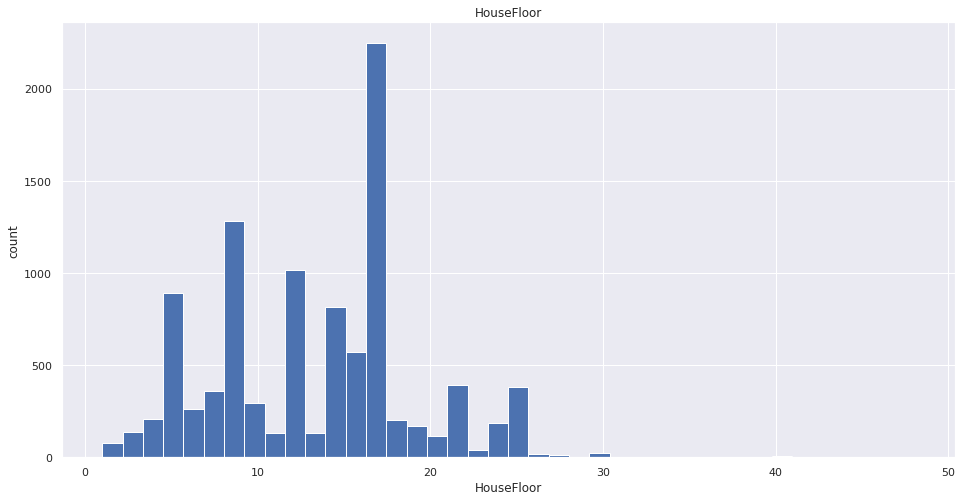

In [85]:
plt.figure(figsize = (16, 8))

reduce_train_df['HouseFloor'].hist(bins=40)
plt.ylabel('count')
plt.xlabel('HouseFloor')

plt.title('HouseFloor')
plt.show()

In [86]:
r_train_df['Healthcare_1'].value_counts(sort=True)

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [87]:
r_train_df.loc[(r_train_df['Healthcare_1'].isna()),'Healthcare_1'] = r_train_df['Healthcare_1'].quantile(.25)

## 4.2 Замена категориальных признаков по колонкам: Ecology_2, Ecology_3 and Shops_2

In [88]:
binary_to_numbers = {'A' : 0, 'B' : 1}

In [89]:
r_train_df['Ecology_2'] = r_train_df['Ecology_2'].replace(binary_to_numbers)
r_train_df['Ecology_3'] = r_train_df['Ecology_3'].replace(binary_to_numbers)
r_train_df['Shops_2'] = r_train_df['Shops_2'].replace(binary_to_numbers)

## 4.3 MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min) -> [0, 1]

Применим MinMaxScaler для:
    -Ecology_1;
    -Social_1;
    -Social_2;
    -Social_3;
    -Healthcare_1;
    -Healthcare_2;
    -Shops_1.

In [90]:
feature_names = ['Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']

In [91]:
scaler = MinMaxScaler()
r_train_df[feature_names] = scaler.fit_transform(r_train_df[feature_names])

In [92]:
r_train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.887200,54.811092,34.066360,10.701660,8.526700,13.406100,3.989866e+03,0.227757,0.990300,0.972500,0.333612,0.274082,0.057015,0.157239,0.219915,0.183970,0.917500,214138.937500
std,4859.01902,43.587592,0.811629,16.265171,12.639672,2.886579,5.241148,5.883421,2.005003e+05,0.228076,0.098015,0.163543,0.236929,0.211829,0.169022,0.172505,0.248935,0.208973,0.275139,92872.273438
min,0.00000,0.000000,1.000000,25.410513,15.001234,5.082103,1.000000,1.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,42.363713,24.467186,8.639177,4.000000,9.000000,1.974000e+03,0.033815,1.000000,1.000000,0.081081,0.073804,0.000000,0.072180,0.000000,0.043478,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.633652,32.007210,10.526731,7.000000,14.000000,1.977000e+03,0.144527,1.000000,1.000000,0.337838,0.270526,0.014184,0.072180,0.166667,0.130435,1.000000,192269.648438
75%,12592.50000,75.000000,2.000000,64.929474,41.237284,10.526731,12.000000,17.000000,2.001000e+03,0.375155,1.000000,1.000000,0.486486,0.373196,0.035461,0.204166,0.333333,0.260870,1.000000,249135.460938
max,16798.00000,209.000000,5.000000,275.645294,233.949310,34.003376,42.000000,48.000000,2.005201e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,633233.437500


In [93]:
r_train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [94]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                 'HouseYear',  'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

target_name = 'Price'

## 5. Функции предобработки данных

In [159]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Заменяем 0 комнат и более 6 на 1 комнату

        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms'] = 1
        
        # Корректируем Square (Общую площадь)
        
        X.loc[(r_train_df['Rooms'] <= 3) & (X['Square'] > 100), 'Square'] \
        = X['Square'] / 1
        X.loc[(X['Rooms'] < 3) & (X['Square'] < 10), 'Square'] = X['Square'] * 10
        X.loc[(X['Rooms'] == 3) & (X['Square'] < 70), 'Square'] = X['Square'].quantile(.75)
        X.loc[(X['Rooms'] == 2) & (X['Square'] < 70), 'Square'] = X['Square'].quantile(.5)
        X.loc[(X['Rooms'] == 1) & (X['Square'] < 25), 'Square'] = X['Square'].quantile(.25)
        
        
        # Корректируем KitchenSquare (Площадь кухни)

        X.loc[(X['KitchenSquare'] >= 10) & (X['Square'] > 100),'KitchenSquare'] = 20
        X.loc[(X['KitchenSquare'] < 10) & (X['Square'] < 100),'KitchenSquare'] = X['Square'] * 0.2
        X.loc[(X['KitchenSquare'] < 10) & (X['Square'] > 100),'KitchenSquare'] = X['Square'] * 0.2
        X.loc[(X['KitchenSquare'] > 10) & (X['Square'] < 100),'KitchenSquare'] = X['Square'] * 0.2
        
        # Корректируем HouseYear (Год постройки)
        
        X.loc[(X['HouseYear'] == 4968), 'HouseYear'] = 1968
        
        # Корректируем LifeSquare (жилую площадь)
        
        koef_Life_Square = (X['LifeSquare'] / X['Square']).quantile(.5)
        X.loc[(X['LifeSquare'] <= 15),'LifeSquare'] = X['Square'] * koef_Life_Square
        X.loc[(X['LifeSquare'].isna()),'LifeSquare'] = X['Square'] * koef_Life_Square
        X.loc[(X['LifeSquare'] > X['Square']),'LifeSquare'] = X['Square'] * koef_Life_Square
        
        
        # Корректируем HouseFloor (этажность)
        
        X.loc[(X['HouseFloor'] <  X['Floor']) | (X['HouseFloor'] >  48),'HouseFloor'] = X['Floor']
        
        # Убираем NaN по колонке Healthcare_1
        
        X.loc[(X['Healthcare_1'].isna()),'Healthcare_1'] = X['Healthcare_1'].quantile(.25)
        
        return X

In [166]:
class FeatureModify():
    """Изменение категориальных признаков"""
    
    def __init__(self):
        self.binary_to_numbers = None
    
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        
    def transform(self, X):
                        
        # Замена категориальных признаков по колонкам: Ecology_2, Ecology_3 and Shops_2 (Binary features)
            
        X['Ecology_2'] = X['Ecology_2'].replace(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].replace(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(self.binary_to_numbers)
        
        # MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min) -> [0, 1]¶
        
        feature_names = ['Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']
        scaler = MinMaxScaler()
        X[feature_names] = scaler.fit_transform(X[feature_names])
        
        # Удаляем колонку ID
     
        if 'Id' in X.columns:
            X.drop('Id', axis=1, inplace=True)
        
        return X

## 6. Разбиение на train / test

In [167]:
train_df = reduce_mem_usage(pd.read_csv(Train_DataSet_Path))
test_df = reduce_mem_usage(pd.read_csv(Test_DataSet_Path))

X = train_df.drop(columns=target_name)
y = train_df[target_name]

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.61 MB
Decreased by 60.0%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.28 MB
Decreased by 61.8%


In [168]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [169]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)


X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [170]:
features_mod = FeatureModify()
features_mod.fit(X_train, y_train)

X_train = features_mod.transform(X_train)
X_valid = features_mod.transform(X_valid)
test_df = features_mod.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 18), (3300, 18), (5000, 18))

In [171]:
X_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6.700000e+03,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,50.219104,1.883582,55.858345,34.658993,10.876347,8.418806,13.313284,4.977193e+03,0.227041,0.989851,0.972836,0.332588,0.273395,0.055654,0.155560,0.218333,0.181667,0.915672
std,43.523441,0.808911,21.195635,16.422413,3.527732,5.199539,5.867829,2.449501e+05,0.229591,0.100238,0.162574,0.237061,0.212602,0.166168,0.172065,0.248369,0.206924,0.277900
min,0.000000,1.000000,25.494402,15.001234,5.098880,1.000000,1.000000,1.912000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1.000000,42.418411,24.311564,8.644208,4.000000,9.000000,1.973000e+03,0.033815,1.000000,1.000000,0.081081,0.073804,0.000000,0.072180,0.000000,0.043478,1.000000
50%,35.000000,2.000000,52.659378,31.882460,10.531876,7.000000,14.000000,1.977000e+03,0.138268,1.000000,1.000000,0.337838,0.270526,0.014184,0.072180,0.166667,0.130435,1.000000
75%,75.000000,2.000000,65.671501,42.055665,10.531876,12.000000,17.000000,2.000000e+03,0.372680,1.000000,1.000000,0.486486,0.373196,0.035461,0.204166,0.333333,0.217391,1.000000
max,209.000000,5.000000,641.065186,638.163208,120.941200,42.000000,48.000000,2.005201e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 7. Построение модели

In [172]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

Train R2:	0.959
Test R2:	0.701


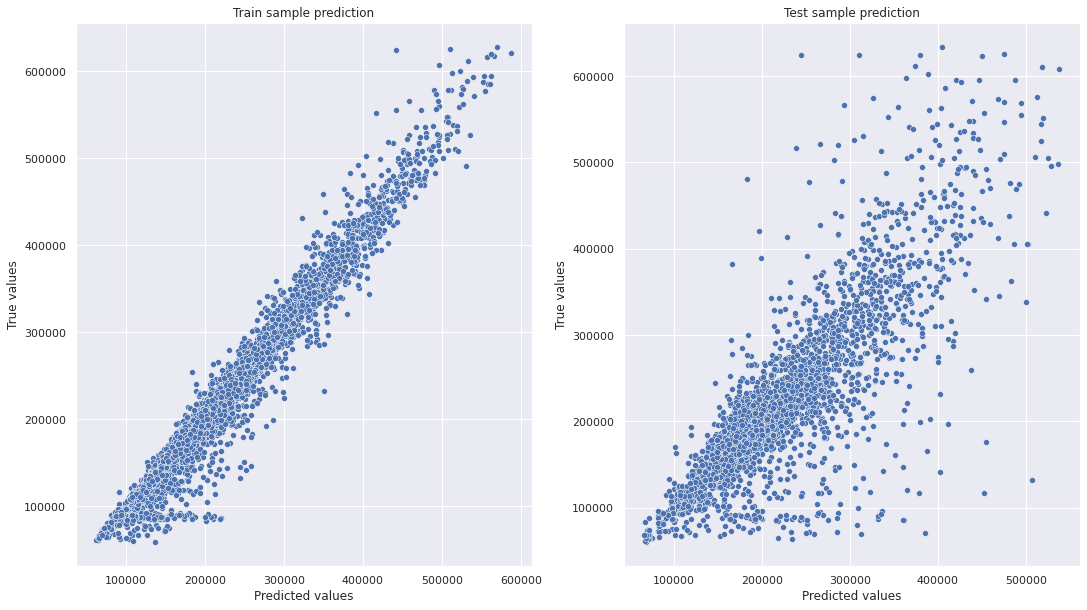

In [173]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [174]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, \
                                                                              shuffle=True, random_state=21))
cv_score

array([0.6728818 , 0.71906492, 0.69920621])

In [175]:
cv_score.mean()

0.6970509784239386

Важность признаков

In [176]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),
                                  columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.360713
11,Social_1,0.107806
12,Social_2,0.075892
7,HouseYear,0.058211
13,Social_3,0.056685
3,LifeSquare,0.054279
1,Rooms,0.048898
0,DistrictId,0.046197
6,HouseFloor,0.044746
8,Ecology_1,0.038044


Другие модели для сравнения:
catboost, lightgbm, xgboost

In [179]:
#from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
#from sklearn.linear_model import LinearRegression

#lr = LinearRegression()
#gb = GradientBoostingRegressor()

#stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
#stack.fit(X_train, y_train)

In [180]:
#y_train_preds = stack.predict(X_train)
#y_test_preds = stack.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

метрика R2 уменьшилась на последующих моделях

## 8. Прогноз на тестовом Dataset

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [181]:
test_df.shape

(5000, 18)

In [182]:
test_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,44,1.0,36.847630,19.094183,7.369526,5,9.0,1970,0.069217,1,1,0.324324,0.222575,0.000000,0.213652,0.166667,0.043478,1
1,62,1.0,42.493908,25.637827,10.000000,7,17.0,2017,0.138268,1,1,0.027027,0.024372,0.007092,0.067024,0.000000,0.000000,0
2,27,2.0,53.361038,32.194286,10.672208,19,19.0,1977,0.405086,1,1,0.121622,0.091145,0.000000,0.067024,0.000000,0.043478,1
3,23,3.0,66.285126,33.893826,13.257026,2,2.0,1965,0.026967,1,1,0.027027,0.016231,0.000000,0.067024,0.000000,0.000000,1
4,74,1.0,53.837055,32.481483,10.767411,8,17.0,1977,0.593023,1,1,0.472973,0.398996,0.028369,0.204166,0.000000,0.260870,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,2.0,53.361038,30.339945,10.672208,6,6.0,1962,0.133483,1,1,0.418919,0.314618,0.028369,0.067024,0.166667,0.086957,1
4996,38,3.0,93.698120,56.530838,10.000000,21,27.0,2018,0.116415,1,1,0.202703,0.138462,0.014184,0.107239,0.000000,0.304348,1
4997,101,1.0,33.656723,19.003260,6.731345,2,5.0,1966,0.074143,1,1,0.378378,0.336505,0.007092,0.209321,0.333333,0.217391,1
4998,10,1.0,38.635155,20.976257,7.727031,8,14.0,1970,0.170618,1,1,0.445946,0.412794,0.035461,0.067024,0.000000,0.478261,1


In [183]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv'

In [ ]:
predictions = rf_model.predict(test_df)
predictions

In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)